**Урок 10. Машинный перевод. Модель seq2seq и механизм внимания**

Разобраться с моделькой перевода как она устроена
запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта с вниманием и без внимания
оценить качество насколько корректно переводит (для теста отобрать примеры с увеличением длины текста) (так как оценка визуальная достаточно 20-ти примеров в тестовой выборке)


In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
#Скачиваем датасет
!wget http://www.manythings.org/anki/rus-eng.zip

--2022-07-14 13:03:59--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14819554 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.13M  24.4MB/s    in 0.6s    

2022-07-14 13:04:00 (24.4 MB/s) - ‘rus-eng.zip’ saved [14819554/14819554]



In [3]:
#Создаем папку и извлекаем туда файлы из архива
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [4]:
# Загружаем файл
path_to_file = "/content/rus-eng/rus.txt"

In [5]:
# Откроем пример строки
f = open(path_to_file)
for line in f:
    print(line)
    break

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)



In [6]:
''' ПРЕДОБРАБОТКА ТЕКСТА'''

#функция препроцессинга
def preprocess_sentence(w):
    #переводим предложение к нижнему регистру и удалем начальные и конечные пробелы
    w = w.lower().strip()

    # отделяем пробелом слово и следующую за ним пунктуацию
    w = re.sub(r"([?.!,])", r" \1 ", w)
    # убираем множественные проблемы (заменяем одним)
    w = re.sub(r'[" "]+', " ", w)

   # все, кроме букв и знаков пунктуации, заменяем пробелом
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)
  
   #удаляем лишние пробелы в начале и конце
    w = w.strip()

    # Добавляем стартовый и конечный токены <start> и <end>
    # теперь модель знает, где начинать и заканчивать предсказания
    w = '<start> ' + w + ' <end>'
    return w

In [7]:
'''СОЗДАНИЕ ДАТАСЕТА'''

# 1. Удаление акцентов
# 2. Чистка последовательности
# 3. Возвращаем пары слов: [ENG, RUS]

def create_dataset(path, num_examples):
  # считываем строки файла
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  # каждую строку сплитуем по \t и берем первые два объекта - это и будут слова английское и русское слова (фразы)
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
 
  return zip(*word_pairs)

In [8]:
# Токенизация

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    # преобразовываем фразу в последовательность индексов
    tensor = lang_tokenizer.texts_to_sequences(lang)

    # выравниваем последовательность так, чтобы
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [9]:
# Загрузчик датасета

def load_dataset(path, num_examples=None):
  # создаем пары английское слово (фраза) - русское слово (фраза)
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

input_tensor, target_tensor

(array([[    1,  5674,    24, ...,     0,     0,     0],
        [    1,   198,     3, ...,     0,     0,     0],
        [    1,   298,     3, ...,     0,     0,     0],
        ...,
        [    1,    19, 20543, ...,     0,     0,     0],
        [    1,    19,     9, ...,     0,     0,     0],
        [    1,    19,    60, ...,     0,     0,     0]], dtype=int32),
 array([[  1,  27,   3, ...,   0,   0,   0],
        [  1,  27,   3, ...,   0,   0,   0],
        [  1,  27,   3, ...,   0,   0,   0],
        ...,
        [  1,  28, 377, ...,   0,   0,   0],
        [  1,  28, 113, ...,   2,   0,   0],
        [  1,  28, 113, ...,   0,   0,   0]], dtype=int32))

In [11]:
# Найдем максимальную длину полученных последовательностей в тензорах

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [12]:
# Сформируем тренировочный и валидационный датасеты в соотношении 80/20
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Длина полученных наборов данных
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [13]:
# функция вывода преобразования текста из токена

def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[13])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[13])

Input Language; index to word mapping
1 ----> <start>
163 ----> деньги
44 ----> за
8 ----> это
7 ----> не
11429 ----> возвращаются
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
30 ----> it's
6603 ----> non
6604 ----> refundable
3 ----> .
2 ----> <end>


Создаем tensorflow dataset

In [15]:
# Зададим значения параметров
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

# Теперь создаем датасет
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

# Делим на батчи и параметром drop_reminder убираем лишний батч мЕньшего размера, если при разбиении такой образуется
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

Модель машинного перевода (без внимания)

In [17]:
'''1 ЭТАП - ENCODER'''

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
      super(Encoder, self).__init__()

      self.batch_sz = batch_sz
      self.enc_units = enc_units
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      self.gru = tf.keras.layers.GRU(self.enc_units,
                                    return_sequences=False,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')


    def call(self, x, hidden):
      x = self.embedding(x)
      output, state = self.gru(x, initial_state = hidden)
      # print(f'Output_shape: {output.shape}, State_shape: {state.shape}') # они будут одинаковые
      return state

    def initialize_hidden_state(self):
      #создаем тензор из нулей размера (батч, кол-во ячеек)- скрытое состояние, которое будет входить в первый узел будет нулевым
      return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# инициализитеруем начальное скрытое состояние (из нулей)
sample_hidden = encoder.initialize_hidden_state()

# применяем энкодер (к входному батчу и скрытому состоянию) - получаем конечное выходное скрытое состояние
sample_hidden = encoder(example_input_batch, sample_hidden)

# print ('Форма выхода энкодера: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [19]:
'''2 ЭТАП - DECODER'''

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden):
        # x shape после прохождения через эмбеддинг == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # отправляем в GRU входные данные и скрытое состояние (от энкодера)
        #выход GRU (batch_size, timesteps, units)
        #размер возвращаемого внутреннего состояния (batch_size, units)
        output, state = self.gru(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # x shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [20]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

#применяем декодер к случайному батчу из равномерного распределения (размер: батч,1) и выходу энкодера
decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)
decoder_sample_x.shape, decoder_sample_h.shape

(TensorShape([64, 7334]), TensorShape([64, 1024]))

Подготовка и обучение модели

In [21]:
'''КОМПИЛЯЦИЯ'''

# оптимизатор
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# функция потерь
# здесь важно сделать так, чтобы через токены маски (0) не проходил градиент
def loss_function(real, pred): 

    #делаем инверсию значений сравнения каждого из real с нулем (возвращается true, если 0 или false, если не 0), где 0 - это максирующий токен 
    mask = tf.math.logical_not(tf.math.equal(real, 0))

    #применяем функцию ошибок к реальным данным и предсказанным
    loss_ = loss_object(real, pred)

    #приводим тензор mask к новому типу loss_.dtype
    mask = tf.cast(mask, dtype=loss_.dtype)

    #умножаем loss_ на mask
    loss_ *= mask

    # возвращаем среднее значениe всех элементов
    return tf.reduce_mean(loss_)

In [22]:
'''CHECKPOINT'''

checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [23]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    # перечисляем операции для автоматического дифференцирования
    with tf.GradientTape() as tape:

        # получаем выход encoder
        enc_hidden = encoder(inp, enc_hidden)

        # помещаем его в скрытое состояние decoder
        dec_hidden = enc_hidden

        # формируем вход декодера:

        # берем список длины батч из индексов тега <start> (1)
        # приписываем списку размерность 1 сзади (батч, 1)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
          # помещаем enc_output в decoder
          predictions, dec_hidden = decoder(dec_input, dec_hidden)

          # считаем функцию потерь 
          loss += loss_function(targ[:, t], predictions)

          # используем teacher forcing (приписываем списку размерность 1 сзади)
          # посылаем dec_input на вход декордера 
          dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    #переменные
    variables = encoder.trainable_variables + decoder.trainable_variables

    #вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    
    #оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [24]:
EPOCHS = 50

# Идем по эпохам и считаем loss
for epoch in range(EPOCHS):
    start = time.time()

    # инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

        # делаем шаг обучения. находим ошибку по батчу
        batch_loss = train_step(inp, targ, enc_hidden)

        # считаем накопленный ошибку
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    # выводим лосс по каждой эпохе и время 
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7662
Epoch 1 Batch 100 Loss 1.8548
Epoch 1 Batch 200 Loss 1.7763
Epoch 1 Batch 300 Loss 1.7934
Epoch 1 Batch 400 Loss 1.5479
Epoch 1 Batch 500 Loss 1.5184
Epoch 1 Batch 600 Loss 1.5031
Epoch 1 Batch 700 Loss 1.4264
Epoch 1 Batch 800 Loss 1.2629
Epoch 1 Batch 900 Loss 1.2345
Epoch 1 Batch 1000 Loss 1.2667
Epoch 1 Batch 1100 Loss 1.1998
Epoch 1 Batch 1200 Loss 1.0692
Epoch 1 Loss 1.5148
Time taken for 1 epoch 68.04487085342407 sec

Epoch 2 Batch 0 Loss 0.9822
Epoch 2 Batch 100 Loss 1.0644
Epoch 2 Batch 200 Loss 1.0142
Epoch 2 Batch 300 Loss 0.9167
Epoch 2 Batch 400 Loss 0.8626
Epoch 2 Batch 500 Loss 0.8896
Epoch 2 Batch 600 Loss 0.8197
Epoch 2 Batch 700 Loss 0.7925
Epoch 2 Batch 800 Loss 0.7492
Epoch 2 Batch 900 Loss 0.8843
Epoch 2 Batch 1000 Loss 0.7642
Epoch 2 Batch 1100 Loss 0.7826
Epoch 2 Batch 1200 Loss 0.8597
Epoch 2 Loss 0.8688
Time taken for 1 epoch 58.54895567893982 sec

Epoch 3 Batch 0 Loss 0.4975
Epoch 3 Batch 100 Loss 0.6021
Epoch 3 Batch 200 Loss 0.544

In [25]:
def evaluate(sentence):
    '''
    Функция повторяет шаг обучения, но бзе использования teacher forcing. 
    Входным сигналом для декодера на каждом временном шаге являются его предыдущие предсказания вместе со скрытым состоянием и выходным сигналом энсодера.
    '''
    #препоцессим предложение
    sentence = preprocess_sentence(sentence)
    #разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    #добиваем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_inp,
                                                          padding='post')
    #преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    # инициализируем входной хидден из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
    #подаем inputs и hidden в encoder
    enc_hidden = encoder(inputs, hidden)

    #инициализируем входной хидден декодера -- выходной хидден энкодера
    dec_hidden = enc_hidden
    #вход декодера -- список [индекс start] размера(1,1)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        #получаем выход декодера
        predictions, dec_hidden = decoder(dec_input, dec_hidden)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        #заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

        # предсказанный predicted ID подаем обратно в декодер (добавляем ось - будет размер (1,1), т к сеть принимает на вход объекты батчами)
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [26]:
# функция для перевода
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [27]:
# загружаем последний checkpoint из checkpoint_dir

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Проверяем качество перевода

In [28]:
translate('работа')

Input: <start> работа <end>
Predicted translation: the work is coming . <end> 


In [29]:
translate('Хорошая работа')

Input: <start> хорошая работа <end>
Predicted translation: good work . <end> 


In [30]:
translate('Я люблю работать')

Input: <start> я люблю работать <end>
Predicted translation: i like to work . <end> 


In [31]:
translate('Я люблю работать по выходным')

Input: <start> я люблю работать по выходным <end>
Predicted translation: i love to work . <end> 


In [32]:
translate('Я люблю работать по выходным дням')

Input: <start> я люблю работать по выходным дням <end>
Predicted translation: i love to work . <end> 


In [33]:
translate('Я не люблю работать по выходным дням, люблю отдыхать')

Input: <start> я не люблю работать по выходным дням , люблю отдыхать <end>
Predicted translation: i don't like chess . <end> 


Можно наблюдать, как качество перевода снижается, вместе с  тем, что предложения становятся длинее и сложнее.

Обучим модель машинного перевода с вниманием

In [34]:
'''1 ЭТАП - ENCODER (аналогичен первой модели без внимания)'''

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [35]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# инициализируем начальное скрытое состояние из нулей
sample_hidden = encoder.initialize_hidden_state()
#получаем выходы энкодера по каждому символу и последнее скрытое состояние
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))

print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [36]:
'''СЛОЙ ВНИМАНИЯ'''

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):

        # values - выходы из encoder-a по всем символам - входы в декодер = sample_output
        # query - последний выход из encoder-a = sample_hidden

        # query hidden state shape == (batch_size, hidden size)
        # values shape == (batch_size, max_len, hidden size)

        # добавляем размерность по индексу 1
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        
        #применяем к векторам скрытого состояния и выходов энкодера полносвязный слой: (выход (batch_size, 1, units) и (batch_size, max_length, units))
        #складываем полученные векторы, применяем к сумме тангенс
        # выход (batch_size, max_length, units)
        #проводим результат через dense слой выход (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        # print((self.W1(query_with_time_axis).shape))
        # print((self.W2(values).shape))
        # print((self.W1(query_with_time_axis) + self.W2(values)).shape)
        # print(score.shape)

        # attention_weights shape == (batch_size, max_length, 1)
        # получаем вероятностное распределение
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        # умножаем веса внимания умножаем на векторы значенй выход (batch_size, max_len, hidden size)
        context_vector = attention_weights * values
        #находим сумму по стобцам - общую сумму контекста для (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [37]:
attention_layer = BahdanauAttention(10)

#передаем выход энкодера и его последовательность скрытых состояний
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [38]:
'''2 ЭТАП - DECODER'''

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # используем слой внимания
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        # получаем выходы слоя внимания 
        # context_vector shape == (batch_size, hidden_size)
        # attention_weights shape == (batch_size, max_len, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        #соединяем выход эмбеддинга с вектором контекста и подаем навход RNN
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # (batch_size, 1, hidden_size) --> output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [39]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходам энкодера
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7334)


In [40]:
'''CHECKPOINT'''

checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [41]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    # перечисляем операции для автоматического дифференцирования
    with tf.GradientTape() as tape:

        # получаем выход encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # помещаем его в скрытое состояние decoder
        dec_hidden = enc_hidden

        # формируем вход декодера:

        # берем список длины батч из индексов тега <start> (1)
        # приписываем списку размерность 1 сзади (батч, 1)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
          # помещаем enc_output в decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

          # считаем функцию потерь 
          loss += loss_function(targ[:, t], predictions)

          # используем teacher forcing (приписываем списку размерность 1 сзади)
          # посылаем dec_input на вход декордера 
          dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    #переменные
    variables = encoder.trainable_variables + decoder.trainable_variables

    #вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    
    #оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [42]:
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

    #инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        #делаем шаг обучения
        batch_loss = train_step(inp, targ, enc_hidden)
        #считаем ошибку
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6270
Epoch 1 Batch 100 Loss 2.0128
Epoch 1 Batch 200 Loss 1.8652
Epoch 1 Batch 300 Loss 1.8221
Epoch 1 Batch 400 Loss 1.6708
Epoch 1 Batch 500 Loss 1.6149
Epoch 1 Batch 600 Loss 1.5788
Epoch 1 Batch 700 Loss 1.6209
Epoch 1 Batch 800 Loss 1.4855
Epoch 1 Batch 900 Loss 1.5282
Epoch 1 Batch 1000 Loss 1.5972
Epoch 1 Batch 1100 Loss 1.5486
Epoch 1 Batch 1200 Loss 1.5383
Epoch 1 Loss 1.7164
Time taken for 1 epoch 113.52905201911926 sec

Epoch 2 Batch 0 Loss 1.3546
Epoch 2 Batch 100 Loss 1.4685
Epoch 2 Batch 200 Loss 1.4769
Epoch 2 Batch 300 Loss 1.4813
Epoch 2 Batch 400 Loss 1.4313
Epoch 2 Batch 500 Loss 1.4503
Epoch 2 Batch 600 Loss 1.3903
Epoch 2 Batch 700 Loss 1.4299
Epoch 2 Batch 800 Loss 1.2702
Epoch 2 Batch 900 Loss 1.3477
Epoch 2 Batch 1000 Loss 1.3999
Epoch 2 Batch 1100 Loss 1.2981
Epoch 2 Batch 1200 Loss 1.2578
Epoch 2 Loss 1.3711
Time taken for 1 epoch 101.9352617263794 sec

Epoch 3 Batch 0 Loss 1.2582
Epoch 3 Batch 100 Loss 1.2460
Epoch 3 Batch 200 Loss 1.21

In [43]:
def evaluate_att(sentence):
    #строим матрицу внимания из нулей размера (макс длина таргета, макс длина входа)  
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    #препоцессим предложение
    sentence = preprocess_sentence(sentence)
    #разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    #добиваем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    #преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    # инициализируем входной хидден из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
    #подаем inputs и hidden в encoder
    enc_out, enc_hidden = encoder(inputs, hidden)

    #инициализируем входной хидден декодера -- выходной хидден энкодера
    dec_hidden = enc_hidden
    #вход декодера -- список [индекс start] размера(1,1)  
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        #получаем выход декодера
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # сохраняем веса внимания, чтобы позже визуализировать
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        #заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # предсказанный predicted ID подаем обратно в декодер (размер (1,1))
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [44]:
# визуализация весов внимания
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [45]:
# функция, которая будет переводить и визуализировать
def translate_att(sentence):
    result, sentence, attention_plot = evaluate_att(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [46]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> работа <end>
Predicted translation: do the work is always the job ? <end> 


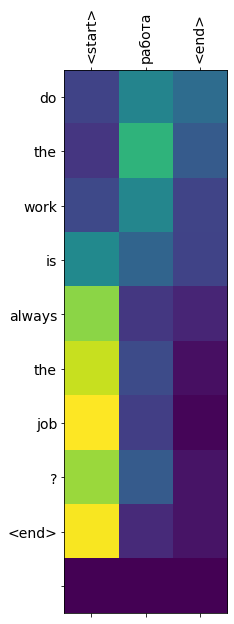

In [47]:
translate_att('работа')

Input: <start> хорошая работа <end>
Predicted translation: good job is good ? <end> 


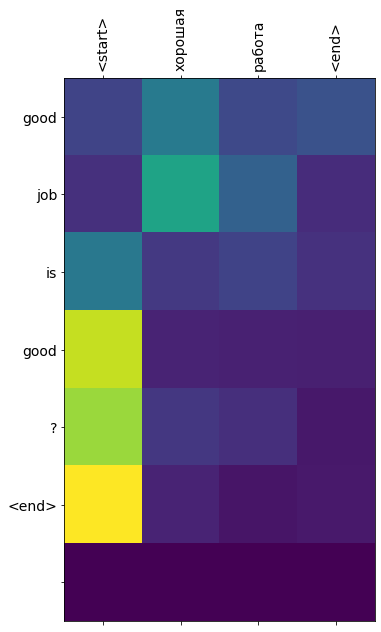

In [48]:
translate_att('Хорошая работа')

Input: <start> я люблю работать <end>
Predicted translation: i love to work ? <end> 


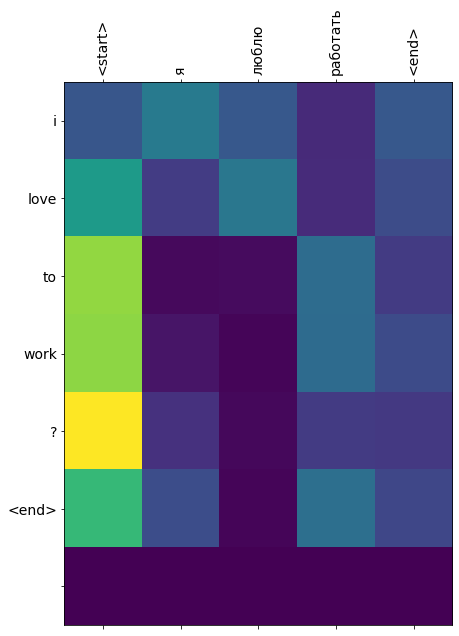

In [49]:
translate_att('Я люблю работать')

Input: <start> я люблю работать по выходным <end>
Predicted translation: i love by work on weekends on weekends work on weekends 


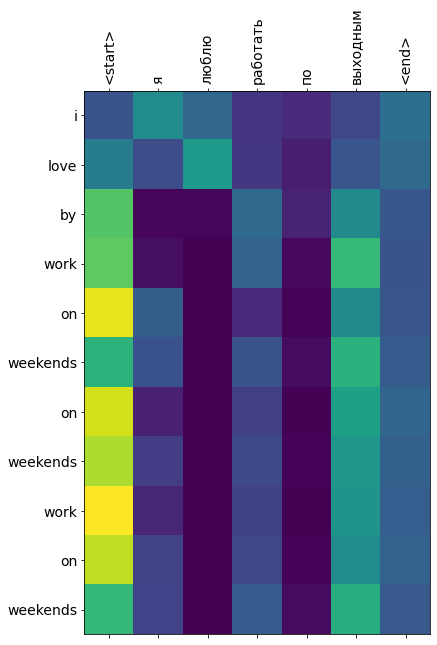

In [50]:
translate_att('Я люблю работать по выходным')

Input: <start> я люблю работать по выходным дням <end>
Predicted translation: i love french and i work on some work ? <end> 


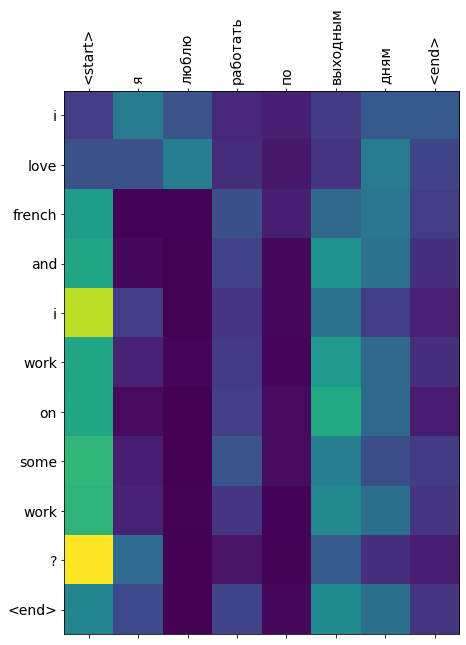

In [51]:
translate_att('Я люблю работать по выходным дням')

Input: <start> я не люблю работать по выходным дням , люблю отдыхать <end>
Predicted translation: i don't love and i love and i love and i 


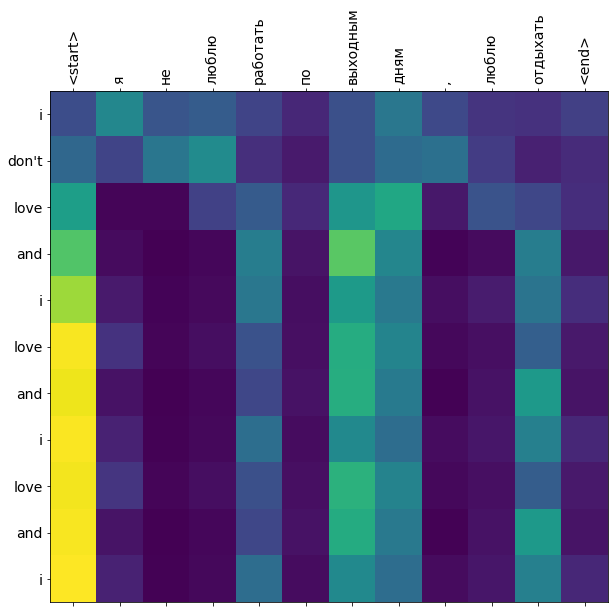

In [52]:
translate_att('Я не люблю работать по выходным дням, люблю отдыхать')

Модель с вниманием лучше, чем без но все равно не идеально